## Harmonic Regression Baseline

https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy

In [134]:


import sys
sys.path.append('..')
from dataset import ModisDataset

import numpy as np
from scipy.optimize import leastsq
import pylab as plt
import sklearn.metrics

dataset = ModisDataset(region="germany",
                       fold="test",
                       znormalize=False,
                       augment=False,
                       overwrite=False,
                       include_time=False,
                       filter_date=(None,None))

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


In [135]:
def fit_harmonic_regression(data, t):

    guess_mean = np.mean(data)
    guess_std = 1.5#3*np.std(data)/(2**0.5)/(2**0.5)
    guess_phase = -1
    guess_freq = 1
    guess_amp = 1.5

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = guess_amp*np.sin(t+guess_phase) + guess_mean

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    return est_amp, est_freq, est_phase, est_mean

def plot_harmonic_regression(data,t,params):
    est_amp, est_freq, est_phase, est_mean = params
    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters

    fine_t = np.arange(min(t),max(t),0.1)
    data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

    fig,ax = plt.subplots(figsize=(12,4))
    ax.plot(t, data)
    #ax.plot(t, data_first_guess, label='first guess')
    ax.plot(fine_t, data_fit, label='after fitting')
    ax.legend()
    plt.show()
    

In [146]:
from tqdm import tqdm

def predict(t, params):
    est_amp, est_freq, est_phase, est_mean = params
    # recreate the fitted curve using the optimized parameters
    return est_amp*np.sin(est_freq*t+est_phase) + est_mean

idx = 0
split_idx = np.where(dataset.date[0].astype(str) == "2010-01-01")[0][0]
    
    
true = list()
pred = list()
for idx in tqdm(range(dataset.data.shape[0])):

    data = dataset.data[idx,:,0]
    t = np.linspace(0, 20*2*np.pi, data.shape[0])

    fit_data = data[:split_idx]
    fit_t = t[:split_idx]
    test_data = data[split_idx:]
    test_t = t[split_idx:]

    params = fit_harmonic_regression(fit_data, fit_t)
    #plot_harmonic_regression(test_data,test_t,params)

    data_pred = predict(test_t, params)

    true.append(test_data)
    pred.append(data_pred)
    
true = np.stack(true)
pred = np.stack(pred)

100%|██████████| 200/200 [00:00<00:00, 1676.36it/s]


## Total Metrics

In [155]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

mae, mse, r2 = calc_metrics(true.reshape(-1), pred.reshape(-1))
dtw = calc_dtw(true, pred)

print(f"MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")

MAE 0.1349, MSE 0.0312, R2 0.4139, DTW 24.5846


In [152]:
for idx in range(200):

    mae, mse, r2 = calc_metrics(true[idx], pred[idx])
    print(f"idx {idx}: MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}")

idx 0: MAE 0.1187, MSE 0.0232, R2 0.2965
idx 1: MAE 0.1543, MSE 0.0373, R2 -0.0067
idx 2: MAE 0.1659, MSE 0.0456, R2 0.1081
idx 3: MAE 0.1319, MSE 0.0345, R2 0.3298
idx 4: MAE 0.1290, MSE 0.0388, R2 0.1671
idx 5: MAE 0.1323, MSE 0.0312, R2 0.4190
idx 6: MAE 0.1638, MSE 0.0376, R2 0.1992
idx 7: MAE 0.1313, MSE 0.0279, R2 0.3858
idx 8: MAE 0.1004, MSE 0.0183, R2 0.6813
idx 9: MAE 0.1298, MSE 0.0323, R2 0.2690
idx 10: MAE 0.1264, MSE 0.0285, R2 0.2698
idx 11: MAE 0.1580, MSE 0.0427, R2 0.2670
idx 12: MAE 0.1189, MSE 0.0243, R2 0.3127
idx 13: MAE 0.0978, MSE 0.0142, R2 0.3143
idx 14: MAE 0.1384, MSE 0.0310, R2 0.2900
idx 15: MAE 0.1457, MSE 0.0321, R2 0.3899
idx 16: MAE 0.1637, MSE 0.0411, R2 0.1348
idx 17: MAE 0.1220, MSE 0.0265, R2 0.2855
idx 18: MAE 0.1268, MSE 0.0276, R2 0.1662
idx 19: MAE 0.1271, MSE 0.0288, R2 0.3525
idx 20: MAE 0.1032, MSE 0.0192, R2 0.3490
idx 21: MAE 0.1322, MSE 0.0314, R2 0.2480
idx 22: MAE 0.1331, MSE 0.0367, R2 0.3271
idx 23: MAE 0.1264, MSE 0.0280, R2 0.4585
i

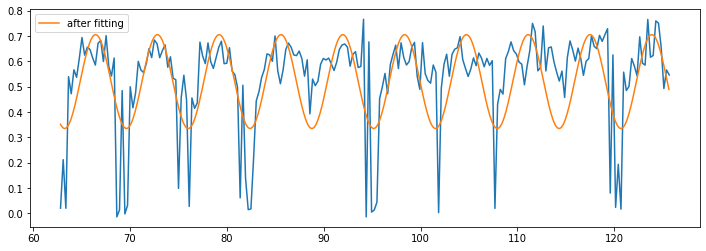

idx 0: MAE 0.1187, MSE 0.0232, R2 0.1187


In [151]:
idx = 0

data = dataset.data[idx,:,0]
t = np.linspace(0, 20*2*np.pi, data.shape[0])

fit_data = data[:split_idx]
fit_t = t[:split_idx]
test_data = data[split_idx:]
test_t = t[split_idx:]

params = fit_harmonic_regression(fit_data, fit_t)

data_pred = predict(test_t, params)

plot_harmonic_regression(test_data,test_t,params)
mae, mse, r2 = calc_metrics(test_data, data_pred)
print(f"idx {idx}: MAE {mae:.4f}, MSE {mse:.4f}, R2 {mae:.4f}")